# Llama from scratch (or how to implement a paper without crying)

## Setting up our dataset

In [104]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from matplotlib import pyplot as plt
import time
import pandas as pd

In [105]:
lines = open('./data/Shakespeare.txt', 'r').read()

vocab = sorted(list(set(lines)))
itos = {i:ch for i, ch in enumerate(vocab)}
stoi = {ch:i for i, ch in enumerate(vocab)}

print(lines[:30])

First Citizen:
Before we proce


In [106]:
# simple tokenization by characters
def encode(s):
    return [stoi[ch] for ch in s]

def decode(l):
    return ''.join([itos[i] for i in l])

print('vocab size:', len(vocab))
decode(encode("hello"))

vocab size: 65


'hello'

In [107]:
MASTER_CONFIG = {
    "vocab_size": len(vocab),
}

In [108]:
dataset = torch.tensor(encode(lines), dtype=torch.int8)
dataset.shape

torch.Size([1115394])

In [109]:
def get_batches(data, split, batch_size, context_window, config=MASTER_CONFIG):
    train = data[:int(.8 * len(data))]
    val = data[int(.8 * len(data)): int(.9 * len(data))]
    test = data[int(.9 * len(data)):]

    if split == 'train':
        batch_data = train
    elif split == 'test':
        batch_data = test
    else:
        batch_data = val

    # pick random starting points
    ix = torch.randint(0, batch_data.size(0) - context_window - 1, (batch_size,))
    x = torch.stack([batch_data[i:i+context_window] for i in ix]).long()
    y = torch.stack([batch_data[i+1:i+context_window+1] for i in ix]).long()
    return x, y

MASTER_CONFIG.update({
    'batch_size': 8,
    'context_window': 16
})

xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

[(decode(xs[i].tolist()), decode(ys[i].tolist())) for i in range(len(xs))]

[('sion prove\nThat ', 'ion prove\nThat e'),
 ('our weakness str', 'ur weakness stre'),
 ('y move your hear', ' move your heart'),
 ('s the foe doth r', ' the foe doth ra'),
 ('and not speak, o', 'nd not speak, ou'),
 ('es and low names', 's and low names,'),
 ('rvant:\nMy lord, ', 'vant:\nMy lord, I'),
 ("chamber: I'll fi", "hamber: I'll fin")]

## Evaluation

In [110]:
@torch.no_grad()  # don't compute gradients for this function
def evaluate_loss(model, config=MASTER_CONFIG):
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = []
        for _ in range(10):
            xb, yb = get_batches(dataset, split, config['batch_size'], config['context_window'])
            _, loss = model(xb, yb)
            losses.append(loss.item())
        out[split] = np.mean(losses)
    model.train()
    return out

## Setting up a working base model

In [111]:
class SimpleBrokenModel(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size']),
        )
        
        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        logits = self.linear(x)
        # logits = F.softmax(a, dim=-1)

        # print(logits.view(-1, self.config['vocab_size']).shape)
        # print(targets.view(-1).shape)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

MASTER_CONFIG.update({
    'd_model': 128,
})
model = SimpleBrokenModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)

model params: 33217


model params: 33217


validation loss:  2.5140052795410157


<Axes: >

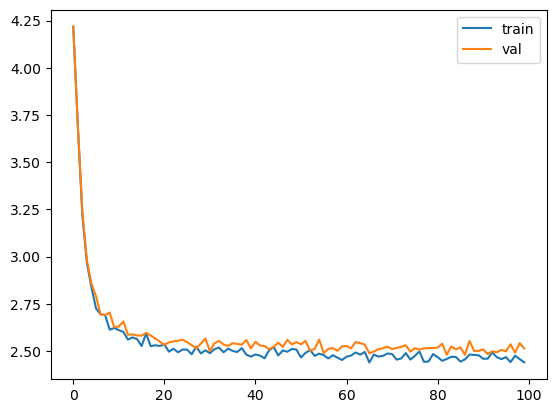

In [112]:
MASTER_CONFIG.update({
    'epochs': 1000,
    'log_interval': 10,
    'batch_size': 32,
})
model = SimpleBrokenModel(MASTER_CONFIG)

optimizer = torch.optim.Adam(
    model.parameters(), 
)

def train(model, optimizer, scheduler=None, config=MASTER_CONFIG, print_logs=False):
    losses = []
    start_time = time.time()
    for epoch in range(config['epochs']):
        optimizer.zero_grad()

        xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])
        logits, loss = model(xs, targets=ys)
        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()

        if epoch % config['log_interval'] == 0:
            batch_time = time.time() - start_time
            x = evaluate_loss(model)
            losses += [x]
            if print_logs:
                print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds {batch_time * (config['epochs'] - epoch)/config['log_interval'] :.3f}")
            start_time = time.time()

            if scheduler:
                print("lr: ", scheduler.get_lr())

    # print(pd.DataFrame(losses))
    print("validation loss: ", losses[-1]['val'])
    return pd.DataFrame(losses).plot()

train(model, optimizer)

In [113]:
def generate(model, config=MASTER_CONFIG, max_new_tokens=30):
    idx = torch.zeros(5, 1).long()
    for _ in range(max_new_tokens):
        # call the model
        logits = model(idx[:, -config['context_window']:])
        # logits = model(idx[:, -1:])
        last_time_step_logits = logits[
            :, -1, :
        ]  # all the batches (1), last time step, all the logits
        p = F.softmax(last_time_step_logits, dim=-1)  # softmax to get probabilities
        idx_next = torch.multinomial(
            p, num_samples=1
        )  # sample from the distribution to get the next token
        idx = torch.cat([idx, idx_next], dim=-1)  # append to the sequence
    
    return [decode(x) for x in idx.tolist()]

generate(model)

['\nT:\nS:\n\nAnthealaoll\nApe:\nY po, ',
 '\nPe\nToyould t adoongis, wew, m ',
 '\nmascowico erse d homowe f y be',
 '\nCld,\nNath ICK:\nsin tht fathan ',
 "\n'll .\nH: sllfoutuse chour, t a"]

## Llama specifics

### RMSNorm

In [114]:
class RMSNorm(nn.Module):
    def __init__(self, layer_shape, eps=1e-8, bias=False):
        super(RMSNorm, self).__init__()
        # self.register_parameter("scale", nn.Parameter(torch.ones(layer_shape)))
        self.scale = nn.Parameter(torch.ones(layer_shape))

    def forward(self, x):
        """
        assumes shape is (batch, seq_len, d_model)
        """
        # frob norm is not the same as RMS. RMS = 1/sqrt(N) * frob norm
        ff_rms = torch.linalg.norm(x, dim=(1,2)) * x[0].numel() ** -.5
        raw = x / ff_rms.unsqueeze(-1).unsqueeze(-1)
        return self.scale[:x.shape[1], :].unsqueeze(0) * raw # todo: self.scale[:x.shape[1], :] -> self.scale

config = {
    'batch_size': 5,
    'context_window': 11,
    'd_model': 13,
}
batch = torch.randn((config['batch_size'], config['context_window'], config['d_model']))
m = RMSNorm((config['context_window'], config['d_model']))
g = m(batch)
print(g.shape)

torch.Size([5, 11, 13])


#### Test

In [115]:
# scaled_batch.var(dim=(1,2))
assert torch.linalg.norm( torch.arange(5).float() ) == (torch.arange(5).float() ** 2 ).sum() ** .5
rms = torch.linalg.norm( torch.arange(5).float() ) * (torch.arange(5).numel() ** -.5)
assert torch.allclose(torch.linalg.norm(torch.arange(5).float() / rms), torch.tensor(5 ** .5))
ff_rms = torch.linalg.norm(batch, dim=(1,2)) * batch.shape[1:].numel() ** -.5

# RMS for sure
ffx = torch.zeros_like(batch)
for i in range(batch.shape[0]):
    ffx[i] = batch[i] / ff_rms[i]
assert torch.allclose(torch.linalg.norm(ffx, dim=(1,2)) ** 2, torch.tensor(143).float())
assert torch.allclose(ffx, g)

#### SimpleModel_RMS

model params: 35265


validation loss:  2.4915894508361816


<Axes: >

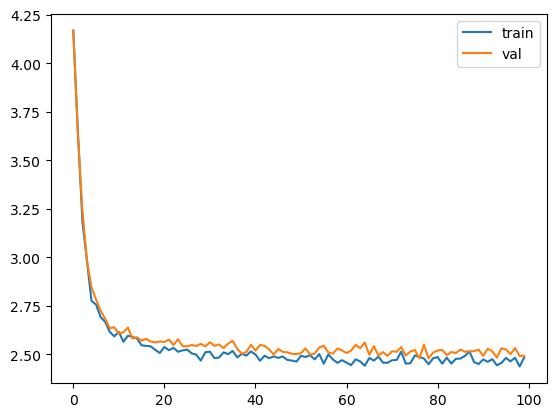

In [116]:
class SimpleModel_RMS(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        x = self.rms(x) # rms pre-normalization
        logits = self.linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

model = SimpleModel_RMS(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)

### Rotary Embeddings

In [117]:
def get_rotary_matrix(context_window, embedding_dim):
    R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
    for position in range(context_window):
        for i in range(embedding_dim//2):
            theta = 10000. ** (-2.*(i - 1) / embedding_dim)
            m_theta = position * theta
            R[position, 2*i,2*i] = np.cos(m_theta)
            R[position, 2*i,2*i+1] = - np.sin(m_theta)
            R[position, 2*i+1,2*i] = np.sin(m_theta)
            R[position, 2*i+1,2*i+1] = np.cos(m_theta)
    return R

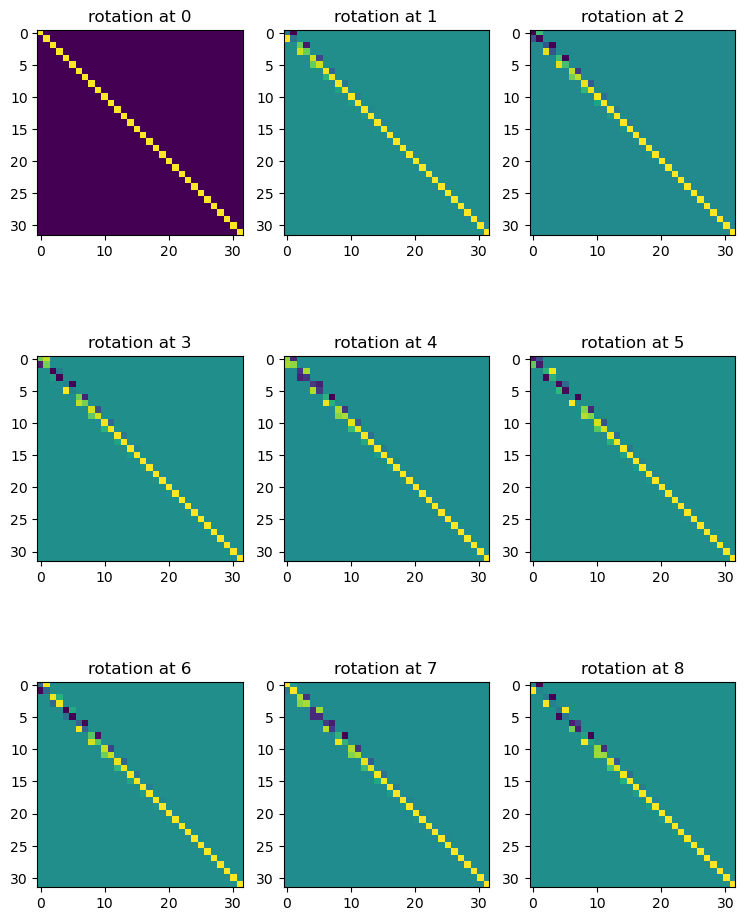

In [118]:
K = 3
config = {
    'batch_size': 10,
    'd_model': 32,
    'n_heads': 8,
    'context_window': K**2,
}
batch = torch.randn(1, config['context_window'], config['d_model'])
R = get_rotary_matrix(config['context_window'], config['d_model'])
fig, ax = plt.subplots(K, K, figsize=(K * 3, K * 4))

for i in range(K):
    for j in range(K):
        ax[i, j].imshow(R[i * K + j, :, :].detach().numpy())
        ax[i, j].set_title(f'rotation at {i * K + j}')

#### Test

In [119]:
config = {
    'd_model': 128,
    'context_window': 16,
}

R = get_rotary_matrix(config['context_window'], config['d_model'])
x = torch.randn(config['d_model'])
y = torch.randn(config['d_model'])

m = 3
n = 13

x_m = R[m,:,:] @ x
x_n = R[n,:,:] @ y

assert torch.isclose(x_m @ x_n, x @ R[n-m,:,:] @ y)

#### RoPEAttentionHead

In [120]:
config = {
    'batch_size': 10,
    'd_model': 512,
    'n_heads': 8,
    'context_window': 16,
}

class RoPEAttentionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.w_q = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_k = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_v = nn.Linear(config['d_model'], config['d_model'], bias=False)

        self.R = get_rotary_matrix(config['context_window'], config['d_model'])

    def get_rotary_matrix(context_window, embedding_dim):
        R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
        for position in range(context_window):
            for i in range(embedding_dim//2):
                theta = 10000. ** (-2.*(i - 1) / embedding_dim)
                m_theta = position * theta
                R[position, 2*i,2*i] = np.cos(m_theta)
                R[position, 2*i,2*i+1] = - np.sin(m_theta)
                R[position, 2*i+1,2*i] = np.sin(m_theta)
                R[position, 2*i+1,2*i+1] = np.cos(m_theta)
        return R

    def forward(self, x, return_attn_weights=False):
        b, m, d = x.shape
        
        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)

        q_rotated = (torch.bmm(q.transpose(0,1), self.R[:m])).transpose(0,1)
        k_rotated = (torch.bmm(k.transpose(0,1), self.R[:m])).transpose(0,1)

        activations = F.scaled_dot_product_attention(
            q_rotated, k_rotated, v, dropout_p =.1, is_causal=True
        )
        

        if return_attn_weights:
            attn_mask = torch.tril(torch.ones((m,m)), diagonal=0)
            attn_weights = torch.bmm(q_rotated, k_rotated.transpose(1,2)) / np.sqrt(d) + attn_mask
            # print(torch.exp(attn_weights[1][0])/torch.exp(attn_weights[1][0]).sum())
            attn_weights = F.softmax(attn_weights, dim=-1)
            # print(attn_weights[1][0])
            return activations, attn_weights
        return activations

layer = RoPEAttentionHead(config)
batch = torch.randn((config['batch_size'], config['context_window'], config['d_model']))
output, attn_weights = layer(batch, return_attn_weights=True)

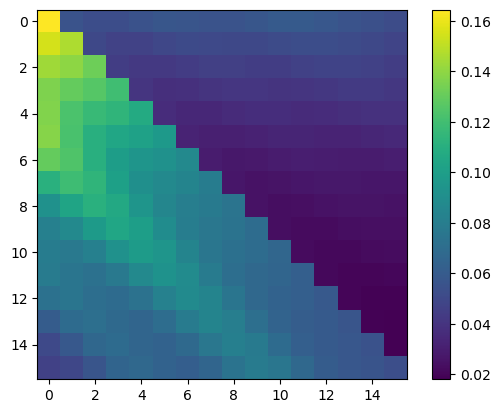

In [121]:
layer = RoPEAttentionHead(MASTER_CONFIG)
batch = torch.ones((MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model']))
output, attn_weights = layer(batch, return_attn_weights=True)

plt.imshow(attn_weights[0].detach().numpy())
plt.colorbar()

In [122]:
# Attention Implementation

batch_size, context_length, embedding_size = 32, 64, 128

x = torch.randn((batch_size, context_length, embedding_size))
W_q = torch.randn((embedding_size, embedding_size))
W_k = torch.randn((embedding_size, embedding_size))
W_v = torch.randn((embedding_size, embedding_size))

q = x @ W_q
k = x @ W_k
v = x @ W_v
attn_weights = (q @ k.transpose(1,2)) / np.sqrt(embedding_size)
activations = attn_weights @ v
activations.shape

torch.Size([32, 64, 128])

#### Multi-Head

In [123]:
# definitely there's an optimization we could make where we cache the rotation matrices, but skip.
class RoPEMaskedMultiheadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.heads = nn.ModuleList([
            RoPEAttentionHead(config) for _ in range(config['n_heads'])
        ])
        self.linear = nn.Linear(config['n_heads'] * config['d_model'], config['d_model'])
        self.dropout = nn.Dropout(.1)

    def forward(self, x):
        heads = [h(x) for h in self.heads]
        x = torch.cat(heads, dim=-1)
        x = self.linear(x)
        x = self.dropout(x)
        return x

MASTER_CONFIG.update({
    'n_heads': 8,
})
layer = RoPEMaskedMultiheadAttention(MASTER_CONFIG)
batch = torch.ones((MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model']))
output = layer(batch)
output.shape

torch.Size([32, 16, 128])

In [124]:
class RopeModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.rope_attention = RoPEMaskedMultiheadAttention(config)

        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
        )

        self.last_linear = nn.Linear(config['d_model'], config['vocab_size'])

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)

        # one block of attention
        x = self.rms(x) # rms pre-normalization
        x = x + self.rope_attention(x)

        x = self.rms(x) # rms pre-normalization
        x = x + self.linear(x)

        logits = self.last_linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

model = RopeModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])
logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())

model params: 559681


Epoch 0 | val loss 4.083 | Time 0.037 | ETA in seconds 18.692
Epoch 10 | val loss 3.076 | Time 0.234 | ETA in seconds 116.983
Epoch 20 | val loss 2.815 | Time 0.225 | ETA in seconds 112.057
Epoch 30 | val loss 2.716 | Time 0.234 | ETA in seconds 116.144
Epoch 40 | val loss 2.677 | Time 0.204 | ETA in seconds 101.373
Epoch 50 | val loss 2.578 | Time 0.198 | ETA in seconds 97.878
Epoch 60 | val loss 2.539 | Time 0.200 | ETA in seconds 98.610
Epoch 70 | val loss 2.516 | Time 0.218 | ETA in seconds 107.578
Epoch 80 | val loss 2.479 | Time 0.245 | ETA in seconds 120.782
Epoch 90 | val loss 2.475 | Time 0.215 | ETA in seconds 105.734
Epoch 100 | val loss 2.437 | Time 0.234 | ETA in seconds 114.598
Epoch 110 | val loss 2.448 | Time 0.212 | ETA in seconds 103.489
Epoch 120 | val loss 2.420 | Time 0.199 | ETA in seconds 96.982
Epoch 130 | val loss 2.371 | Time 0.219 | ETA in seconds 106.727
Epoch 140 | val loss 2.390 | Time 0.207 | ETA in seconds 100.709
Epoch 150 | val loss 2.381 | Time 0.236 

<Axes: >

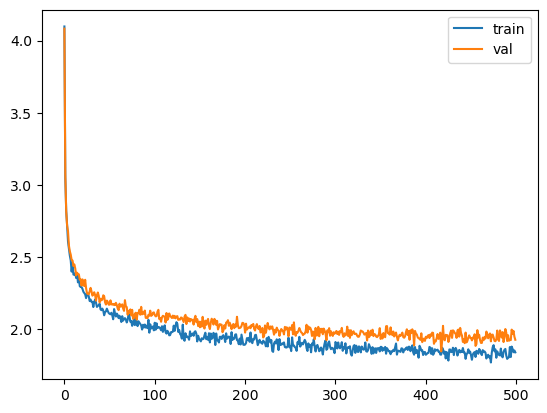

In [125]:
MASTER_CONFIG.update({
    "epochs": 5000,
    "log_interval": 10,
})
train(model, optimizer,print_logs=True)

In [126]:
generate(model, config=MASTER_CONFIG)

['\nTo grofes had lighanour the ba',
 '\nI treses.\n\nIf peews eren, I I ',
 '\nFor bed my low seemble oss mor',
 '\n\nTAUS:\nBeshen, mine ailm wing ',
 '\nAnd and surieversy\nWe child!\nT']

## SwiGLU

In [127]:
class SwiGLU(nn.Module):
    """
    Swish-Gated Linear Unit
    https://arxiv.org/pdf/2002.05202v1.pdf
    """
    def __init__(self, size):
        super().__init__()
        self.config = config
        self.linear_gate = nn.Linear(size, size)
        self.linear = nn.Linear(size, size)
        # self.beta = torch.randn(1, requires_grad=True)

        self.beta = torch.ones(1, requires_grad=True)
        # nn.Parameter(torch.ones(1))
        # self.register_parameter("beta", self.beta)

    def forward(self, x): 
        swish_gate = self.linear_gate(x) * torch.sigmoid(self.beta * self.linear_gate(x))
        out = swish_gate * self.linear(x)
        return out

model params: 592705
Epoch 0 | val loss 4.017 | Time 0.025 | ETA in seconds 12.701
Epoch 10 | val loss 3.111 | Time 0.238 | ETA in seconds 118.643
Epoch 20 | val loss 2.856 | Time 0.211 | ETA in seconds 105.167
Epoch 30 | val loss 2.752 | Time 0.208 | ETA in seconds 103.483
Epoch 40 | val loss 2.669 | Time 0.214 | ETA in seconds 106.264
Epoch 50 | val loss 2.644 | Time 0.196 | ETA in seconds 96.998
Epoch 60 | val loss 2.553 | Time 0.209 | ETA in seconds 103.410
Epoch 70 | val loss 2.502 | Time 0.258 | ETA in seconds 127.308
Epoch 80 | val loss 2.460 | Time 0.243 | ETA in seconds 119.739
Epoch 90 | val loss 2.505 | Time 0.220 | ETA in seconds 107.878
Epoch 100 | val loss 2.448 | Time 0.239 | ETA in seconds 117.103
Epoch 110 | val loss 2.422 | Time 0.251 | ETA in seconds 122.636
Epoch 120 | val loss 2.375 | Time 0.232 | ETA in seconds 113.261
Epoch 130 | val loss 2.374 | Time 0.219 | ETA in seconds 106.896
Epoch 140 | val loss 2.368 | Time 0.241 | ETA in seconds 117.079
Epoch 150 | val l

<Axes: >

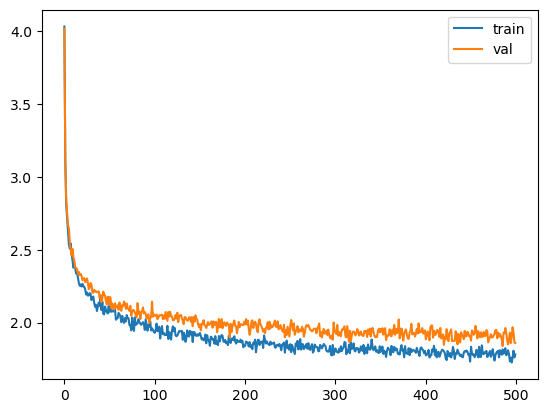

In [128]:
class RopeModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.rope_attention = RoPEMaskedMultiheadAttention(config)

        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
        )

        self.last_linear = nn.Linear(config['d_model'], config['vocab_size'])

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)

        # one block of attention
        x = self.rms(x) # rms pre-normalization
        x = x + self.rope_attention(x)

        x = self.rms(x) # rms pre-normalization
        x = x + self.linear(x)

        logits = self.last_linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

model = RopeModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer, print_logs=True)

In [129]:
generate(model, config=MASTER_CONFIG)

['\nThat course of henjy to sment?',
 '\nThath hamber, more th: net his',
 '\nFRIOLAND:\nDwe\nIs.\nBonsome\nus d',
 '\nI would signt:\nLet, my worn af',
 "\nWhat's eptakethn Holm too, gre"]

## Final LLaMa

In [130]:
from collections import OrderedDict

# add RMSNorm and residual conncection
class LlamaBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.rms = RMSNorm((config['context_window'], config['d_model']))

        self.attention = RoPEMaskedMultiheadAttention(config)
        self.feedforward = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
        )

    def forward(self, x):
        x = self.rms(x) # rms pre-normalization
        x = x + self.attention(x)

        x = self.rms(x) # rms pre-normalization
        x = x + self.feedforward(x)
        return x

class Llama(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embeddings = nn.Embedding(config['vocab_size'], config['d_model'])
        self.llama_blocks = nn.Sequential(
            OrderedDict([(f"llama_{i}", LlamaBlock(config)) for i in range(config['n_layers'])])
        )

        self.ffn = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embeddings(idx)
        x = self.llama_blocks(x)
        logits = self.ffn(x)

        if targets is None:
            return logits

        else:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

model params: 2370241
Epoch 0 | val loss 4.137 | Time 0.113 | ETA in seconds 113.364
Epoch 10 | val loss 3.497 | Time 0.986 | ETA in seconds 984.995
Epoch 20 | val loss 3.122 | Time 0.867 | ETA in seconds 865.597
Epoch 30 | val loss 2.981 | Time 0.918 | ETA in seconds 915.140
Epoch 40 | val loss 2.794 | Time 0.884 | ETA in seconds 880.243
Epoch 50 | val loss 2.694 | Time 0.894 | ETA in seconds 889.532
Epoch 60 | val loss 2.622 | Time 0.907 | ETA in seconds 901.140
Epoch 70 | val loss 2.598 | Time 0.986 | ETA in seconds 979.167
Epoch 80 | val loss 2.545 | Time 0.943 | ETA in seconds 935.825
Epoch 90 | val loss 2.483 | Time 0.901 | ETA in seconds 892.552
Epoch 100 | val loss 2.414 | Time 0.885 | ETA in seconds 876.554
Epoch 110 | val loss 2.456 | Time 0.905 | ETA in seconds 894.661
Epoch 120 | val loss 2.384 | Time 0.863 | ETA in seconds 852.701
Epoch 130 | val loss 2.362 | Time 0.863 | ETA in seconds 851.355
Epoch 140 | val loss 2.288 | Time 0.867 | ETA in seconds 854.907
Epoch 150 | va

<Axes: >

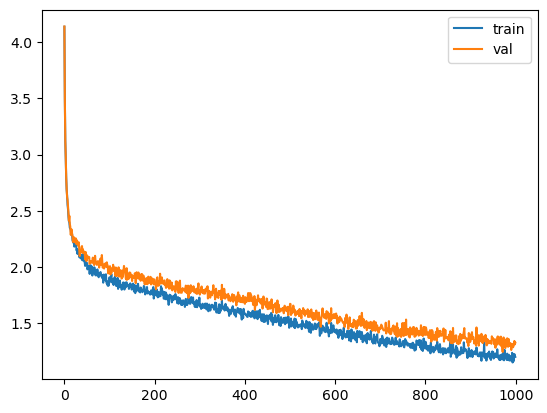

In [131]:
MASTER_CONFIG.update({
    'n_layers': 4,
    'epochs': 10000,
})

llama = Llama(MASTER_CONFIG)
optimizer = torch.optim.Adam(llama.parameters())
train(llama, optimizer, config=MASTER_CONFIG,print_logs=True)

In [132]:
print(generate(llama, MASTER_CONFIG, 500)[0])



Duke me before, and Cleve, I do fear's there freit this banest his Ner love, ro to Romeo trettemen; gringed.

As an quitious no the chso
rhink bed for, fiver'
King so serram' so were a' thris of Henred, are maze; all das terbutiouse, heaptess as this,
Regage dre: For the sater,
For injust Must full no.

My spatt hearn! Boy straighb hear it princes tir. Him mist ho! the day lord, Norrous town.

RUTK:
He pro:
Proth for ace of him.
Pin'st a Word way: bukes, the rover tove yet? He'Xuge!

YORK:
Ther


#### Test

In [133]:
xs, ys = get_batches(dataset, 'test', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = llama(xs, ys)

print(loss)

tensor(1.3914, grad_fn=<NllLossBackward0>)


## Miscellaneous

### Check for Gradient Flows

In [134]:
# print the percentage that are near 0
def show_grads(model, tol=1e-2):
    return sorted([(name, 100.0 * float(torch.sum(torch.abs(param) <= tol)) / float(param.nelement())) for name, param in model.named_parameters() if param.requires_grad], key=lambda t: t[1], reverse=True)

show_grads(llama)

[('llama_blocks.llama_0.attention.linear.weight', 22.7996826171875),
 ('llama_blocks.llama_3.attention.linear.weight', 21.649169921875),
 ('llama_blocks.llama_1.attention.linear.weight', 20.1019287109375),
 ('llama_blocks.llama_2.attention.linear.weight', 20.053863525390625),
 ('llama_blocks.llama_1.attention.heads.2.w_v.weight', 17.218017578125),
 ('llama_blocks.llama_1.attention.heads.1.w_v.weight', 17.108154296875),
 ('llama_blocks.llama_3.attention.heads.4.w_v.weight', 17.08984375),
 ('llama_blocks.llama_3.attention.heads.7.w_v.weight', 16.88232421875),
 ('llama_blocks.llama_1.attention.heads.6.w_v.weight', 16.619873046875),
 ('llama_blocks.llama_3.attention.heads.6.w_v.weight', 16.534423828125),
 ('llama_blocks.llama_3.attention.heads.3.w_v.weight', 16.522216796875),
 ('llama_blocks.llama_1.attention.heads.0.w_v.weight', 16.461181640625),
 ('llama_blocks.llama_1.attention.heads.7.w_v.weight', 16.3330078125),
 ('llama_blocks.llama_1.attention.heads.3.w_v.weight', 16.2841796875),
 (

### Experiment with hyperparams

model params: 2370241


/home/simon/anaconda3/envs/dl-fundamentals/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


lr:  [0.0009999457184159408]
lr:  [0.0009961510274583004]
lr:  [0.0009869757772816292]
lr:  [0.0009725204933511963]
lr:  [0.0009529435502760634]
lr:  [0.0009284594366176498]
lr:  [0.0008993364049014041]
lr:  [0.0008658935325782156]
lr:  [0.0008284972261358946]
lr:  [0.0007875572066618724]
lr:  [0.0007435220208394261]
lr:  [0.0006968741265588948]
lr:  [0.0006481246069855613]
lr:  [0.0005978075709959357]
lr:  [0.0005464743013294258]
lr:  [0.0004946872145648923]
lr:  [0.00044301369909075325]
lr:  [0.00039201989856974814]
lr:  [0.0003422645089892466]
lr:  [0.0002942926572257539]
lr:  [0.0002486299281339155]
lr:  [0.0002057766054928797]
lr:  [0.00016620218969383484]
lr:  [0.00013034025177986015]
lr:  [9.85836791664324e-05]
lr:  [7.128036241775617e-05]
lr:  [4.872936226262451e-05]
lr:  [3.117756953567661e-05]
lr:  [1.8816750064937722e-05]
lr:  [1.1779739336260682e-05]
lr:  [1.0054282328142978e-05]
lr:  [1.396862020283371e-05]
lr:  [2.3138198807489664e-05]
lr:  [3.7591595433673565e-05]
lr:  [

<Axes: >

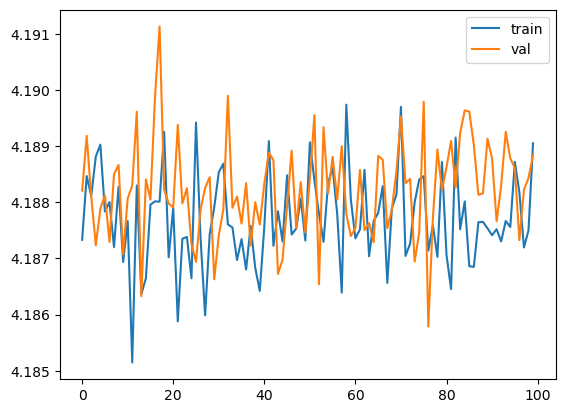

In [135]:
MASTER_CONFIG.update({
    "epochs": 1000
})
llama_with_cosine = Llama(MASTER_CONFIG)
llama_optimizer = torch.optim.Adam(
    llama.parameters(), 
    betas=(.9, .95), 
    weight_decay=.1, 
    eps=1e-9, 
    lr=1e-3
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(llama_optimizer, 300, eta_min=1e-5)
train(llama_with_cosine, llama_optimizer, scheduler=scheduler)

In [136]:
show_grads(llama_with_cosine, 1e-5)

[('llama_blocks.llama_2.attention.linear.weight', 0.034332275390625),
 ('llama_blocks.llama_3.attention.linear.weight', 0.0335693359375),
 ('llama_blocks.llama_0.attention.heads.2.w_k.weight', 0.030517578125),
 ('llama_blocks.llama_0.attention.linear.weight', 0.030517578125),
 ('llama_blocks.llama_1.attention.heads.1.w_k.weight', 0.030517578125),
 ('llama_blocks.llama_1.attention.heads.3.w_k.weight', 0.030517578125),
 ('llama_blocks.llama_1.attention.heads.4.w_q.weight', 0.030517578125),
 ('llama_blocks.llama_1.attention.heads.7.w_k.weight', 0.030517578125),
 ('llama_blocks.llama_1.attention.linear.weight', 0.029754638671875),
 ('llama_blocks.llama_0.attention.heads.1.w_q.weight', 0.0244140625),
 ('llama_blocks.llama_1.attention.heads.5.w_v.weight', 0.0244140625),
 ('llama_blocks.llama_2.attention.heads.2.w_v.weight', 0.0244140625),
 ('llama_blocks.llama_2.attention.heads.5.w_q.weight', 0.0244140625),
 ('llama_blocks.llama_2.attention.heads.7.w_v.weight', 0.0244140625),
 ('llama_blocks